In [1]:
%load_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
cd /Volumes/Data/Stanford/telemedicine/telederm-quality/

/Volumes/Data/Stanford/telemedicine/telederm-quality


In [3]:
import pandas as pd
from torchvision.datasets import ImageFolder
import yaml


import sys
paths = ["src"]
for path in paths:
    if path not in sys.path:
        sys.path.append(path)
    
from utils import *
from segmentation import load_skin_segmentation, load_lesion_segmentation
from detect_quality import load_quality_detectors
import seaborn as sns
from sklearn.linear_model import LogisticRegression


Bad key "text.kerning_factor" on line 4 in
/Users/kailasv/miniconda3/envs/telederm/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [4]:
class DermImages2(ImageFolder):
    def __init__(self, path_to_images, transform=None, transform_target=None, return_path=False):
        super().__init__(path_to_images, 
                         is_valid_file=lambda x: x.split(".")[-1].strip().lower() in ["jpg", "jpeg", "gif", "png", "ppm", "bmp", "pgm", "tif", "tiff", "webp"],               
                         loader=lambda x: x)
        self.num_classes = len(self.classes)
        
        # -- Store transform and label transform functions --
        self.set_transform(transform)
        self.set_target_transform(transform_target)
        
        # -- Return the image path? --
        self.set_return_path(return_path)
        
    def __len__(self):
        return super().__len__()

    def __getitem__(self, idx):   
        # -- Load image (PIL) and label (int) --
        im_path, [im, target] = self.imgs[idx][0], super().__getitem__(idx)
        im = default_loader(im_path)
        # -- Apply transforms --
        if self._transform:
            im = self._transform(im)
        if self._target_transform:
            target = self._target_transform(target)
        ret_vals = [im, target]
        if self.return_im_path:
            ret_vals.append(im_path)
        return tuple(ret_vals)
    
    def set_transform(self, transform):
        self._transform = transform
        
    def set_target_transform(self, target_transform):
        self._target_transform = target_transform
        
    def set_return_path(self, return_path):
        self.return_im_path = return_path

def find_image(file_name, dataset):
    for i, im in enumerate(dataset.imgs):
        if file_name in im[0]:
            return im
        
image_scores = to_numpy(pd.read_excel("data/Labeled_images.xlsx", header=None))
# image_scores = np.concatenate([im[None,:] for i,im in enumerate(image_scores) if i != 28])
# image_scores2 = to_numpy(pd.read_excel("data/Labeled_images--test.xlsx", header=None))
# image_scores = np.concatenate((image_scores, image_scores2))
derm_images = DermImages2("../datasets/acne_stanford/data/")
def excel_idx(idx, excel_arr=image_scores):
    excel = excel_arr[idx]
    return find_image(excel[0], derm_images), excel


In [5]:
def main(args):

    def process_im(im, plot_mask=True):
        """Processes and analyzes a single image.""" 
        set_seeds(args.seed)
        skin_mask = args.skin_segmentation(im)
        lesion_mask = args.lesion_segmentation(im, skin_mask)
        quality_scores = {k:[qii for qi in q for qii in make_list(qi(im,skin_mask,lesion_mask))] 
                            for k,q in args.quality_detectors.items()}


        im = display_tensor_im(im)
        if plot_mask:
            skin_mask = im*display_tensor_im(skin_mask)
            lesion_mask = im*display_tensor_im(lesion_mask)

        # -- Return values for display --
        return quality_scores, to_numpy(im), to_numpy(skin_mask), to_numpy(lesion_mask)

    for im, im_path in load_images(args):
        quality_scores, im, skin_mask, lesion_mask = process_im(im)
        return quality_scores

In [27]:
config = 'config.yaml'
with open(config, 'r') as f:
    config = yaml.load(f)
config['use_gradio'] = False
config['path_to_images'] = ''
args = Bunch(config)
set_seeds(args.seed)

args.skin_segmentation = load_skin_segmentation(args)
args.lesion_segmentation = load_lesion_segmentation(args)
args.quality_detectors = load_quality_detectors(args)

args.quality_detectors
args.path_to_images = excel_idx(0)[0][0]
main(args)

/Users/kailasv/miniconda3/envs/telederm/lib/python3.7/site-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


{'blur': [<detect_quality.FourierBlur at 0x1a319f1690>,
 'lighting': [<detect_quality.DefaultLighting at 0x1a319f1190>,
 'zoom': [<detect_quality.DefaultZoom at 0x1a319f14d0>]}

{'blur': [1.0497234535361117,
  4.048683489757223,
  10.540672634164244,
  -10.035872912914009,
  33.82469944020672,
  8.385729789733887,
  11.895849542617798,
  8.797534245238397,
  3.9959983825683594,
  39.14731502532959],
 'lighting': [28.0,
  28.0,
  0.0,
  28.0,
  28.0,
  33.0,
  33.0,
  0.0,
  33.0,
  33.0,
  37.0,
  37.0,
  0.0,
  37.0,
  37.0,
  42.0,
  42.0,
  0.0,
  42.0,
  42.0,
  47.0,
  47.0,
  0.0,
  47.0,
  47.0,
  229.5,
  229.5,
  0.0,
  229.5,
  229.5,
  229.5,
  229.5,
  0.0,
  229.5,
  229.5,
  229.5,
  229.5,
  0.0,
  229.5,
  229.5,
  229.5,
  229.5,
  0.0,
  229.5,
  229.5,
  229.5,
  229.5,
  0.0,
  229.5,
  229.5,
  26.0,
  31.622448979591837,
  23.348191952951876,
  8.0,
  140.0,
  80.30000000000007,
  86.51020408163266,
  33.91533422917602,
  14.0,
  172.0,
  136.0,
  134.2295918367347,
  31.85715633947081,
  41.0,
  200.0,
  183.5,
  178.3377551020408,
  27.837918330960914,
  85.0,
  222.0,
  225.85000000000008,
  221.42244897959188,
  20.836842031345164,
  

In [28]:
im_analysis = []
im_gt = []
for i in range(len(image_scores)):
    print(i, end="..")
    im, meta = excel_idx(i)
    args.path_to_images = im[0]
    im_analysis.append(main(args))
    im_gt.append({k:k in meta[-1] for k in ['blur', 'lighting', 'zoom']})

0..1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30..31..32..33..34..35..36..37..38..39..40..41..42..43..44..45..46..47..48..49..50..51..52..53..54..55..56..57..58..59..60..61..62..63..64..65..66..67..68..69..70..71..72..73..74..75..76..77..78..79..80..81..82..83..84..85..86..87..88..89..90..91..92..93..94..95..96..97..98..99..100..101..102..103..104..105..106..107..108..109..110..111..112..113..114..115..116..117..118..119..120..121..122..123..124..125..126..127..128..129..130..131..132..133..134..135..136..137..138..139..140..141..142..143..144..145..146..147..148..149..150..151..152..153..154..155..156..157..158..159..160..161..162..163..164..165..166..167..168..169..170..171..172..173..174..175..176..177..178..179..180..181..182..183..184..185..186..187..188..189..190..191..192..193..194..195..196..197..198..199..

In [29]:
len(im_analysis), len(im_gt)

(200, 200)

In [30]:
idxs = {'good':[],'blur':[],'lighting':[],'zoom':[]}
for i,h in enumerate(im_gt):
    for k,v in h.items():
        if v: 
            idxs[k].append(i)
    if not any(h.values()):
        idxs['good'].append(i)

blur


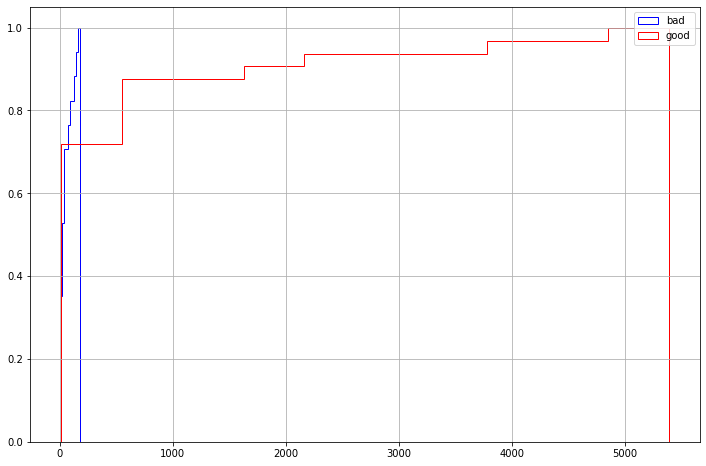

lighting


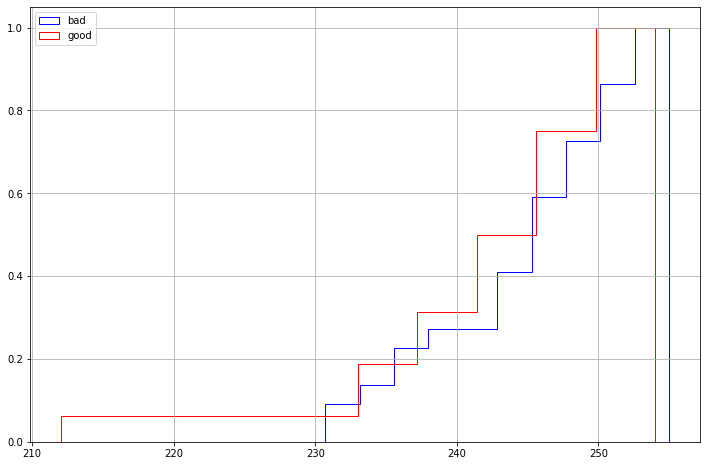

zoom


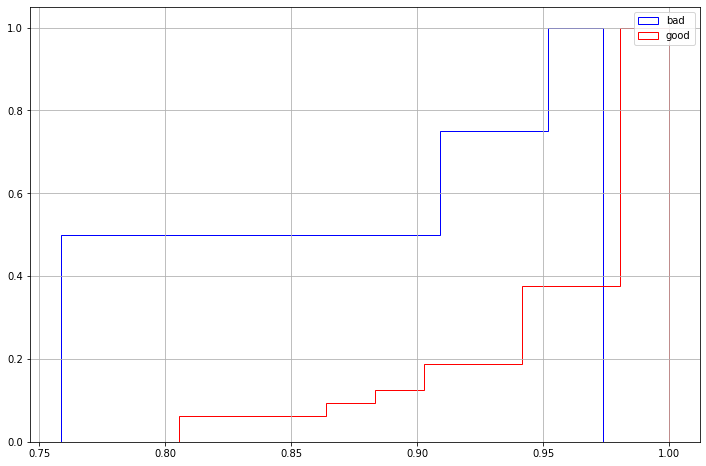

In [31]:
for k in ['blur', 'lighting', 'zoom']:
    print(k, flush=True)
    _=plt.figure(figsize=(12,8))
    _=plt.hist([np.max(a[k]) for i,a in enumerate(im_analysis[:71]) if i in idxs[k]], 
             color='blue', label='bad', density=True, cumulative=True, histtype='step')
    _=plt.hist([np.max(a[k]) for i,a in enumerate(im_analysis[:71]) if i in idxs['good']], 
             color='red', label='good', density=True, cumulative=True, histtype='step')
    _=plt.legend()
    _=plt.grid()
    _=plt.plot()
    _=plt.show()

In [32]:
#sns.pairplot(pd.DataFrame(im_analysis))

In [33]:
# for idx in range(len(image_scores)):
#     _=plt.imshow(load_image(excel_idx(idx)[0][0]))
#     plt.show()

In [34]:
# idx=28
# _=plt.imshow(load_image(excel_idx(idx)[0][0]))
# plt.show()
# # im_gt[idx]
# # im_analysis[idx]

In [243]:
def eval_model(model, train, test, name="test", threshold=None):
    hat = model.predict(train[0])
    if threshold is not None:
        hat_s = model.decision_function(train[0])
        # -- If not confident, just set to 'Good' --
        if len(hat_s.shape) == 1:
            hat[hat_s < threshold] = 0
        else:
            hat[hat_s[:,0] < threshold] = 0
    train_ = np.sum(hat == train[1]) / len(train[1])
    good_idxs = np.where(train[1]==0)[0]
    bad_idxs = np.where(train[1]!=0)[0]
    train_wrongly_rejected = np.sum(hat[good_idxs]!=0) / len(good_idxs)
    train_wrongly_kept = np.sum(hat[bad_idxs]==0) / len(bad_idxs)
    hat = model.predict(test[0])
    if threshold is not None:
        hat_s = model.decision_function(test[0])
        # -- If not confident, just set to 'Good' --
        if len(hat_s.shape) == 1:
            hat[hat_s < threshold] = 0
        else:
            hat[hat_s[:,0] < threshold] = 0
    test_ = np.sum(hat == test[1]) / len(test[1])
    good_idxs = np.where(test[1]==0)[0]
    bad_idxs = np.where(test[1]!=0)[0]
    test_wrongly_rejected = np.sum(hat[good_idxs]!=0) / len(good_idxs)
    test_wrongly_kept = np.sum(hat[bad_idxs]==0) / len(bad_idxs)
    print(f"Train: {train_}\n{name.capitalize()}:  {test_}")
    print(f"Train -- Wrongly rejected: {train_wrongly_rejected}\n      -- Wrongly kept:  {train_wrongly_kept}")
    print(f"{name.capitalize()} -- Wrongly rejected: {test_wrongly_rejected}\n      -- Wrongly kept:  {test_wrongly_kept}")
    

    return (np.where((hat!=0) & (test[1]==0))[0], np.where((hat==0) & (test[1]!=0))[0],
            np.where((hat==0) & (test[1]==0))[0], np.where((hat!=0) & (test[1]!=0))[0])

In [218]:

def range_data(lr, val_, x=np.arange(-5,5.1,.1)):
    acc = []
    wr  = []
    wk  = []
    ck  = []
    cr  = []
    for threshold in x:
        hat_s = lr.decision_function(val_[0])
        hat_h = lr.predict(val_[0])
        # -- If not confident, just set to 'Good' --
        if len(hat_s.shape) == 1:
            hat_h[hat_s < threshold] = 0
        else:
            hat_h[hat_s[:,0] < threshold] = 0
        acc.append(np.sum(hat_h == val_[1]) / len(val_[1]))

        good_idxs = np.where(val_[1]==0)[0]
        wr.append(np.sum(hat_h[good_idxs]!=0) / len(good_idxs))
        ck.append(np.sum(hat_h[good_idxs]==0) / len(good_idxs))

        bad_idxs = np.where(val_[1]!=0)[0]
        wk.append(np.sum(hat_h[bad_idxs]==0) / len(bad_idxs))
        cr.append(np.sum(hat_h[bad_idxs]!=0) / len(bad_idxs))
    return x, acc, wr, wk, ck, cr
def plot_range_data(x, acc, wr, wk, ck, cr):
    _=plt.figure(figsize=(12,8))
    _=plt.plot(x, acc, label="accuracy")
    _=plt.plot(x, wr, label="wrongly rejected")
    _=plt.plot(x, wk, label="wrongly kept")
    _=plt.plot(x, cr, label="correctly rejected")
    _=plt.plot(x, ck, label="correctly kept")
    _=plt.legend(loc='upper left')
    _=plt.grid()
    plt.show()
    
def search_range_data(lr, val_, key='wr', rate=0.25, tol=1e-2):
    
    return search_range_data_(lr, val_, key='wr', rate=rate, 
                tol=tol, max_=6, x_cen=0, x_rng=50, x_step=1)
    
def search_range_data_(lr, val_, key='wr', rate=0.25, tol=1e-2, 
                      max_=10, x_cen=0, x_rng=50, x_step=1):
    
    x_curr = np.arange(x_cen-x_rng, x_cen+x_rng+x_step, x_step)
    x, acc, wr, wk, ck, cr = range_data(lr, val_, x=x_curr)
    d = {'acc':acc, 'wr':wr, 'wk':wk, 'ck':ck, 'cr':cr}
    key = key.lower().strip()
    if key not in d:
        raise
    arr = d[key]
    curr_i = None
    curr_x = None
    curr_d = None
    for i, [xi, ai] in enumerate(zip(x, arr)):
        if curr_i is None or np.abs(ai-rate) < curr_d:
            curr_i = i
            curr_x = xi
            curr_d = np.abs(ai-rate)

    if curr_d < tol or max_==0:
        return curr_x, {k:v[curr_i] for k,v in d.items()}
    
    return search_range_data_(lr=lr, val_=val_, key=key, 
                              rate=rate, tol=tol, 
                              max_=max_-1, x_cen=curr_x, 
                              x_rng=x_rng/10, x_step=x_step/10)






In [70]:
im_analysis

In [229]:
# simple_dataset = np.array(pd.DataFrame([{f"{k}-{j}":vi for k,v in i.items() for j,vi in enumerate(make_list(v))} 
#                                        for i in im_analysis]))
# pcas = [PCA(n_components=15).fit(simple_dataset)]
# simple_dataset = pcas[0].transform(simple_dataset)

a = [np.array([i[k] for i in im_analysis])
         for k in im_analysis[0].keys()]
# -- remove some stuff from lighting --
# a[1] = a[1][:,50:]
pcas = [PCA(n_components=min(ai.shape[1], 7)).fit(ai) for ai in a]
a = [pca.transform(ai) for ai,pca in zip(a,pcas)]
simple_dataset = np.concatenate(a, axis=-1)

for pca in pcas:
    print(pca.explained_variance_)


labels = np.array([0 if not any(i.values()) else 1 for i in im_gt])
labels_multi = np.array([0 if not any(i.values()) else 
                         1 if i["blur"] else 
                         2 if i["lighting"] else 
                         3 
                         for i in im_gt])
rng = np.random.RandomState(1)
shuffle_idx = np.arange(len(labels))
rng.shuffle(shuffle_idx)
simple_dataset = simple_dataset[shuffle_idx]
labels, labels_multi = labels[shuffle_idx], labels_multi[shuffle_idx]

split_idx1 = 120
split_idx2 = 160

[6.81938575e+05 2.09168510e+04 4.67358701e+03 1.11283201e+03
 2.55521019e+02 9.54638732e+01 2.77464550e+01]
[10306.63655798  6347.16947635  1960.39064023  1476.60501687
  1111.55206407   636.89239332   488.07994025]
[0.02084098]


In [230]:
simple_dataset.shape

(200, 15)

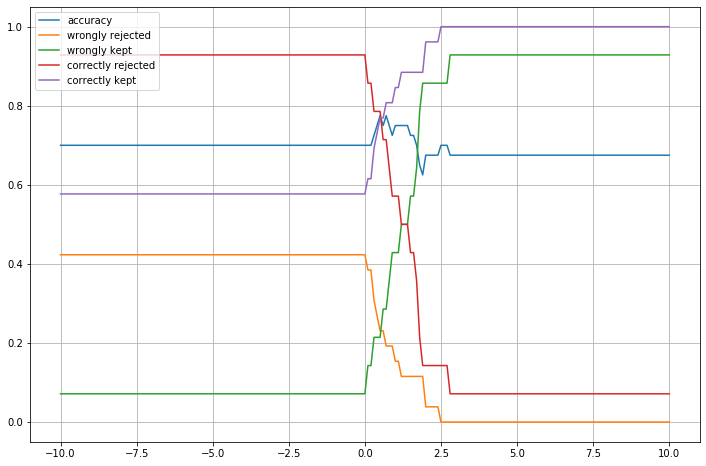

In [247]:
lr = LogisticRegression(max_iter=10000, solver='lbfgs', penalty='none').fit(simple_dataset[:split_idx1], labels[:split_idx1])
val_ = simple_dataset[split_idx1:split_idx2], labels[split_idx1:split_idx2]

x, acc, wr, wk, ck, cr = range_data(lr, val_, x=np.arange(-10,10.1,.1))
plot_range_data(x, acc, wr, wk, ck, cr)
threshold, d = search_range_data(lr, val_, key='wr', 
                                 rate=0.25, tol=1e-2)

In [248]:
# # -- Save model --
# with open("models/logistic_single.pkl", 'wb') as f:
#     pickle.dump({'pcas':pcas, 'model':lr, 'threshold':threshold}, f)

In [249]:
val_wr, val_wk, val_ck, val_cr = eval_model(lr, [simple_dataset[:split_idx1], labels[:split_idx1]],
               [simple_dataset[split_idx1:split_idx2], labels[split_idx1:split_idx2]],
           name="val", threshold=threshold)

Train: 0.7166666666666667
Val:  0.75
Train -- Wrongly rejected: 0.2916666666666667
      -- Wrongly kept:  0.2777777777777778
Val -- Wrongly rejected: 0.2692307692307692
      -- Wrongly kept:  0.21428571428571427


In [250]:
from shutil import copyfile

In [259]:
# -- Display correctly rejected --
print("CORRECTLY REJECTED")

for i in shuffle_idx[val_cr + split_idx1]:
    path = excel_idx(i)[0][0]
    copyfile(path, "data/good_examples/{0}".format(path.split("/")[-1]))
#     print(path)
#     _=plt.imshow(load_image(path))
#     _=plt.show()
print("\n"*3)
# -- Display correctly kept --
print("CORRECTLY KEPT")
for i in shuffle_idx[val_ck + split_idx1]:
    path = excel_idx(i)[0][0]
    copyfile(path, "data/good_examples/{0}".format(path.split("/")[-1]))
    
#     print(path)
#     _=plt.imshow(load_image(path))
#     _=plt.show()

CORRECTLY REJECTED


'data/good_examples/gallery_43807_3217_19585.jpg'

'data/good_examples/gallery_101577_9580_29919.jpg'

'data/good_examples/gallery_23821_1023_1116351747.jpg'

'data/good_examples/gallery_121132_10564_116457.jpg'

'data/good_examples/gallery_66060_7326_161719.jpg'

'data/good_examples/gallery_94299_9154_177757.jpg'

'data/good_examples/gallery_106043_9821_22998.jpg'

'data/good_examples/gallery_94299_9154_10969.jpg'

'data/good_examples/gallery_63458_7459_22488.jpg'

'data/good_examples/gallery_78097_8287_37474.jpg'

'data/good_examples/gallery_122043_10670_2369751.jpg'





CORRECTLY KEPT


'data/good_examples/gallery_103765_9919_127305.jpg'

'data/good_examples/gallery_93094_9517_154094.jpg'

'data/good_examples/gallery_63458_7459_38361.jpg'

'data/good_examples/gallery_25955_1363_25912.jpg'

'data/good_examples/gallery_94299_9154_10944.jpg'

'data/good_examples/gallery_31353_2354_65495.jpg'

'data/good_examples/gallery_35470_2156_23507.jpg'

'data/good_examples/gallery_4562_1917_9174.jpg'

'data/good_examples/gallery_8036_6684_528136.jpg'

'data/good_examples/gallery_59288_6893_161186.jpg'

'data/good_examples/gallery_106533_9891_111850.jpg'

'data/good_examples/gallery_122043_10670_3026922.jpg'

'data/good_examples/gallery_112151_10832_8173.jpg'

'data/good_examples/gallery_33764_2021_66879.jpg'

'data/good_examples/gallery_42993_3112_120496.jpg'

'data/good_examples/gallery_62968_6936_237843.jpg'

'data/good_examples/gallery_35360_2532_29675.jpg'

'data/good_examples/gallery_25955_1363_62568.jpg'

'data/good_examples/gallery_28244_12151_4954.jpg'

In [258]:
# -- Display wrongly rejected --
print("WRONGLY REJECTED")

for i in shuffle_idx[val_wr + split_idx1]:
    path = excel_idx(i)[0][0]
    copyfile(path, "data/bad_examples/{0}".format(path.split("/")[-1]))
    print(path)
#     _=plt.imshow(load_image(path))
#     _=plt.show()
print("\n"*3)
# -- Display wrongly kept --
print("WRONGLY KEPT")
for i in shuffle_idx[val_wk + split_idx1]:
    path = excel_idx(i)[0][0]
    copyfile(path, "data/bad_examples/{0}".format(path.split("/")[-1]))
    print(path)
#     _=plt.imshow(load_image(path))
#     _=plt.show()

WRONGLY REJECTED


'data/bad_examples/gallery_94299_9154_130157.jpg'

../datasets/acne_stanford/data/4/gallery_94299_9154_130157.jpg


'data/bad_examples/gallery_81620_8511_21048.jpg'

../datasets/acne_stanford/data/4/gallery_81620_8511_21048.jpg


'data/bad_examples/gallery_117265_11440_68138.jpg'

../datasets/acne_stanford/data/2/gallery_117265_11440_68138.jpg


'data/bad_examples/gallery_44736_3344_6253.jpg'

../datasets/acne_stanford/data/4/gallery_44736_3344_6253.jpg


'data/bad_examples/gallery_90779_9571_266237.jpg'

../datasets/acne_stanford/data/0/gallery_90779_9571_266237.jpg


'data/bad_examples/gallery_123404_10858_279788.jpg'

../datasets/acne_stanford/data/2/gallery_123404_10858_279788.jpg


'data/bad_examples/gallery_56169_5923_43801.jpg'

../datasets/acne_stanford/data/4/gallery_56169_5923_43801.jpg




WRONGLY KEPT


'data/bad_examples/gallery_82851_8574_45137.jpg'

../datasets/acne_stanford/data/4/gallery_82851_8574_45137.jpg


'data/bad_examples/gallery_66463_7447_4202.jpg'

../datasets/acne_stanford/data/4/gallery_66463_7447_4202.jpg


'data/bad_examples/gallery_19962_713_7352.jpg'

../datasets/acne_stanford/data/0/gallery_19962_713_7352.jpg


In [225]:
_=eval_model(lr, [simple_dataset[:split_idx1], labels[:split_idx1]],
               [simple_dataset[split_idx2:], labels[split_idx2:]],
           name="test", threshold=threshold)

Train: 0.7166666666666667
Test:  0.7
Train -- Wrongly rejected: 0.2916666666666667
      -- Wrongly kept:  0.2777777777777778
Test -- Wrongly rejected: 0.2857142857142857
      -- Wrongly kept:  0.3076923076923077


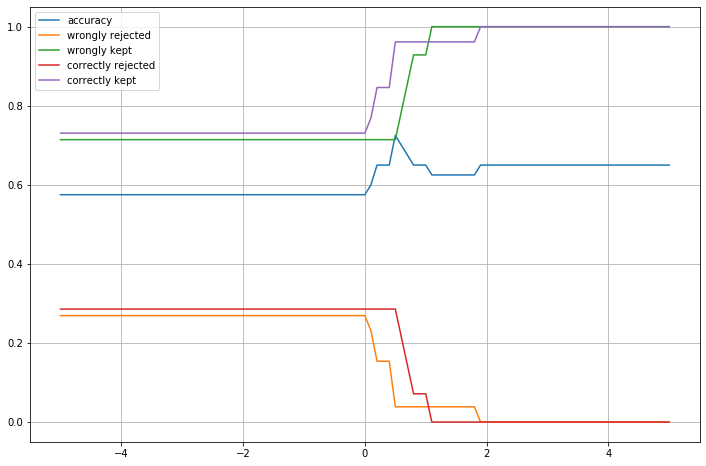

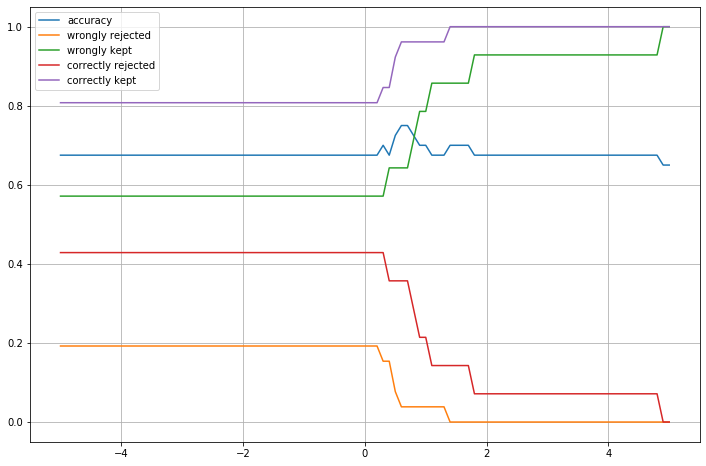

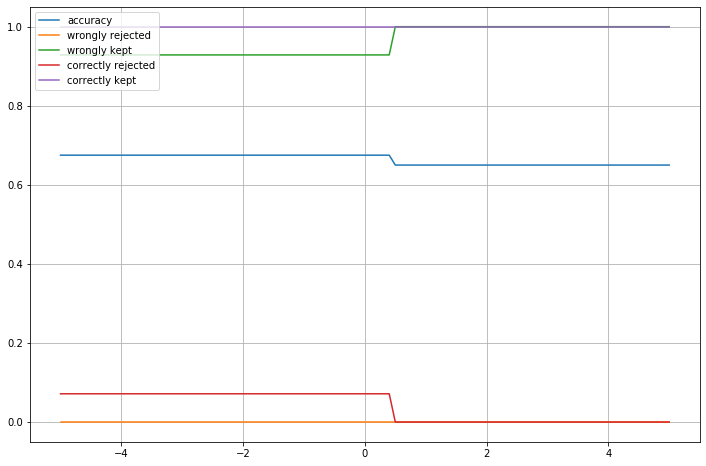

In [242]:
for k in ['blur', 'lighting', 'zoom']:
    labels_multi = np.array([0 if not i[k] else 
                             1 
                         for i in im_gt])
    labels_multi = labels_multi[shuffle_idx]

    lr = LogisticRegression(max_iter=100000, solver='liblinear', penalty='l1').fit(simple_dataset[:split_idx1], labels_multi[:split_idx1])
    val_ = simple_dataset[split_idx1:split_idx2], labels[split_idx1:split_idx2]

    x, acc, wr, wk, ck, cr = range_data(lr, val_)
    plot_range_data(x, acc, wr, wk, ck, cr)
    threshold, _ = search_range_data(lr, val_, key='wr', rate=0.25, tol=1e-2)

#     # -- Save model --
#     with open(f"models/logistic_{k}.pkl", 'wb') as f:
#         pickle.dump({'pcas':pcas, 'model':lr, 'threshold':threshold}, f)

In [235]:
eval_model(lr, [simple_dataset[:split_idx1], labels_multi[:split_idx1]],
               [simple_dataset[split_idx1:split_idx2], labels_multi[split_idx1:split_idx2]],
           name="val", threshold=threshold)


Train: 0.45
Val:  0.575
Train -- Wrongly rejected: 0.16666666666666666
      -- Wrongly kept:  0.7083333333333334
Val -- Wrongly rejected: 0.2692307692307692
      -- Wrongly kept:  0.5714285714285714


(array([ 8, 12, 14, 16, 23, 28, 32]), array([ 4,  7, 10, 18, 21, 22, 27, 30]))

In [236]:
eval_model(lr, [simple_dataset[:split_idx1], labels_multi[:split_idx1]],
               [simple_dataset[split_idx2:], labels_multi[split_idx2:]],
           name="test", threshold=threshold)


Train: 0.45
Test:  0.475
Train -- Wrongly rejected: 0.16666666666666666
      -- Wrongly kept:  0.7083333333333334
Test -- Wrongly rejected: 0.2857142857142857
      -- Wrongly kept:  0.5


(array([ 4,  9, 27, 29]),
 array([ 6, 10, 11, 15, 16, 18, 19, 22, 30, 33, 34, 35, 38]))